In [22]:
# SPHEREX Horizons Batch File

# Horizons Batch api format
# https://ssd-api.jpl.nasa.gov/doc/horizons.html

# the NORAD satellite id for SPHEREx is 63182 [here specified as -163182]
# CENTER='500@399' means coordinate center is GEOCENTRIC (500) @ BODY=EARTH (399)
# Set the Start time to the minimum time allowed for SPHEREx

# VEC_TABLE values
# 1. Position {X, Y, Z}
# 2. State Vector {X, Y, Z, VX, VY, VZ}
# ... others not listed
BATCH_FILE="""
!$$SOF
MAKE_EPHEM=YES
COMMAND=-163182
EPHEM_TYPE=VECTORS
CENTER='500@399'
START_TIME='2025-03-12 03:31:09.186'
STOP_TIME='2025-05-14'
STEP_SIZE='5 MINUTES'
VEC_TABLE='2'
REF_SYSTEM='ICRF'
REF_PLANE='FRAME'
VEC_CORR='NONE'
CAL_TYPE='M'
OUT_UNITS='KM-S'
VEC_LABELS='YES'
VEC_DELTA_T='NO'
CSV_FORMAT='YES'
OBJ_DATA='NO'
"""

In [23]:
import requests
BASE_URL = 'https://ssd.jpl.nasa.gov/api/horizons.api' # FOR GET/URL
BASE_FILE_URL = 'https://ssd.jpl.nasa.gov/api/horizons_file.api' # FOR POST

r = requests.post(BASE_FILE_URL, data={'format': 'text','input': BATCH_FILE}) # takes about 3 seconds to run

In [24]:

def get_csv(table):
    TABLE_START = '$$SOE'
    TABLE_END = '$$EOE'

    table = table.split('\n')
    header = table[table.index(TABLE_START) - 2].split(',')
    rows = table[table.index(TABLE_START) + 1:table.index(TABLE_END)]
    return [h.strip() for h in header], [r.split(',') for r in rows]


header, rows = get_csv(r.text)
    

In [25]:
from astropy.table import Table 
table = Table(rows=rows, names=header)

# JDTDB    Julian Day Number, Barycentric Dynamical Time
# X      X-component of position vector (km)
# Y      Y-component of position vector (km)
# Z      Z-component of position vector (km)
# VX     X-component of velocity vector (km/sec)                           
# VY     Y-component of velocity vector (km/sec)                           
# VZ     Z-component of velocity vector (km/sec)                           
# LT     One-way down-leg Newtonian light-time (sec)
# RG     Range; distance from coordinate center (km)
# RR     Range-rate; radial velocity wrt coord. center (km/sec)
      
# assign units to the columns
from astropy import units as u

# Assign units to the columns
table['JDTDB'].unit = u.day
table['X'].unit = u.km
table['Y'].unit = u.km
table['Z'].unit = u.km
table['VX'].unit = u.km / u.s
table['VY'].unit = u.km / u.s
table['VZ'].unit = u.km / u.s
# table['LT'].unit = u.s
# table['RG'].unit = u.km
# table['RR'].unit = u.km / u.s

# Convert columns to float
for col in ['JDTDB', 'X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'LT', 'RG', 'RR']:
    if col in table.columns:
        # Convert to float
        table[col] = table[col].astype(float)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from typing import cast
import numpy as np


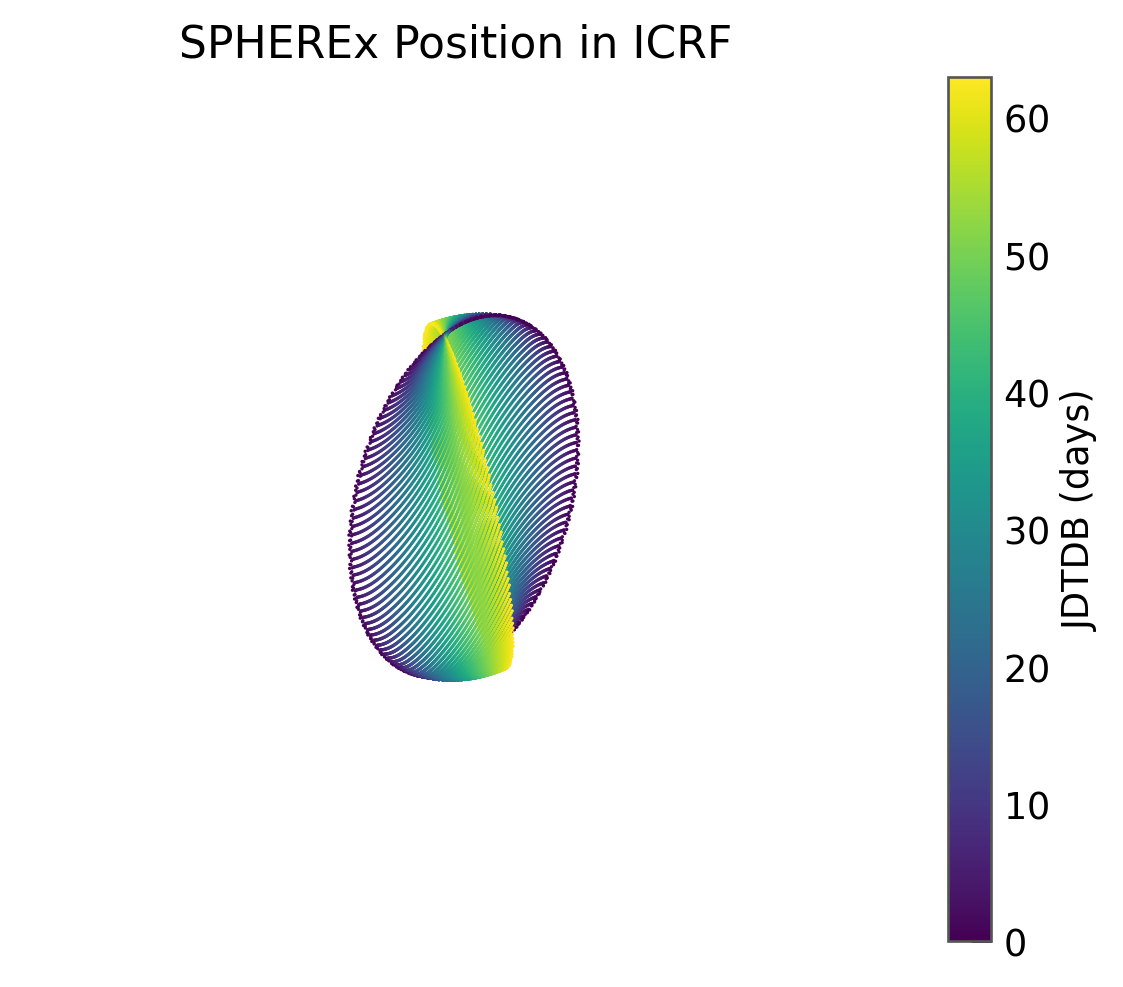

In [ ]:
fig = plt.figure()
ax = cast(Axes3D, fig.add_subplot(111, projection='3d'))
ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title('SPHEREx Position in ICRF')
# ax.plot(table['X'], table['Y'], table['Z'], marker='.', linestyle='', color='b', markersize=1, alpha=1, linewidth=0.5)
ax.scatter(table['X'], table['Y'], table['Z'], c = table['JDTDB'] - table['JDTDB'].min(), cmap='viridis', marker='.', s=1, alpha=1, linewidth=0.5)
plt.colorbar(ax.collections[0], label='JDTDB (days)')
ax.set_aspect('equal')
ax.set_xlim([-10000, 10000])
ax.set_ylim([-10000, 10000])
ax.set_zlim([-10000, 10000])
ax.set_axis_off()

# Comparison using TLE

We can get the current TLE for SPHEREx using the CelesTrak api `https://celestrak.org/NORAD/elements/gp.php?CATNR=63182&FORMAT=tle`
Other formats are the more verbose `json` and `csv`

Technically these change over time, but here you can see it is ok for prediction out about +-30 days. This uses [Skyfield](https://rhodesmill.org/skyfield/earth-satellites.html) to perform the coordinate calculation. 

In [ ]:
from skyfield.api import load

max_days = 7.0         # download again once 7 days old
name = 'spherex.tle'  # custom filename, not 'gp.php'


url = "https://celestrak.org/NORAD/elements/gp.php?CATNR=63182&FORMAT=tle"

if not load.exists(name) or load.days_old(name) >= max_days:
    load.download(url, filename=name)
    
    
from skyfield.api import load
from skyfield.iokit import parse_tle_file

ts = load.timescale()

with load.open(name) as f:
    satellites = list(parse_tle_file(f, ts))
    
sat = satellites[0]

In [18]:
geocentric.xyz.km

array([-3337.63661836,  3576.74178259, -5069.19822183])

(-10000.0, 10000.0)

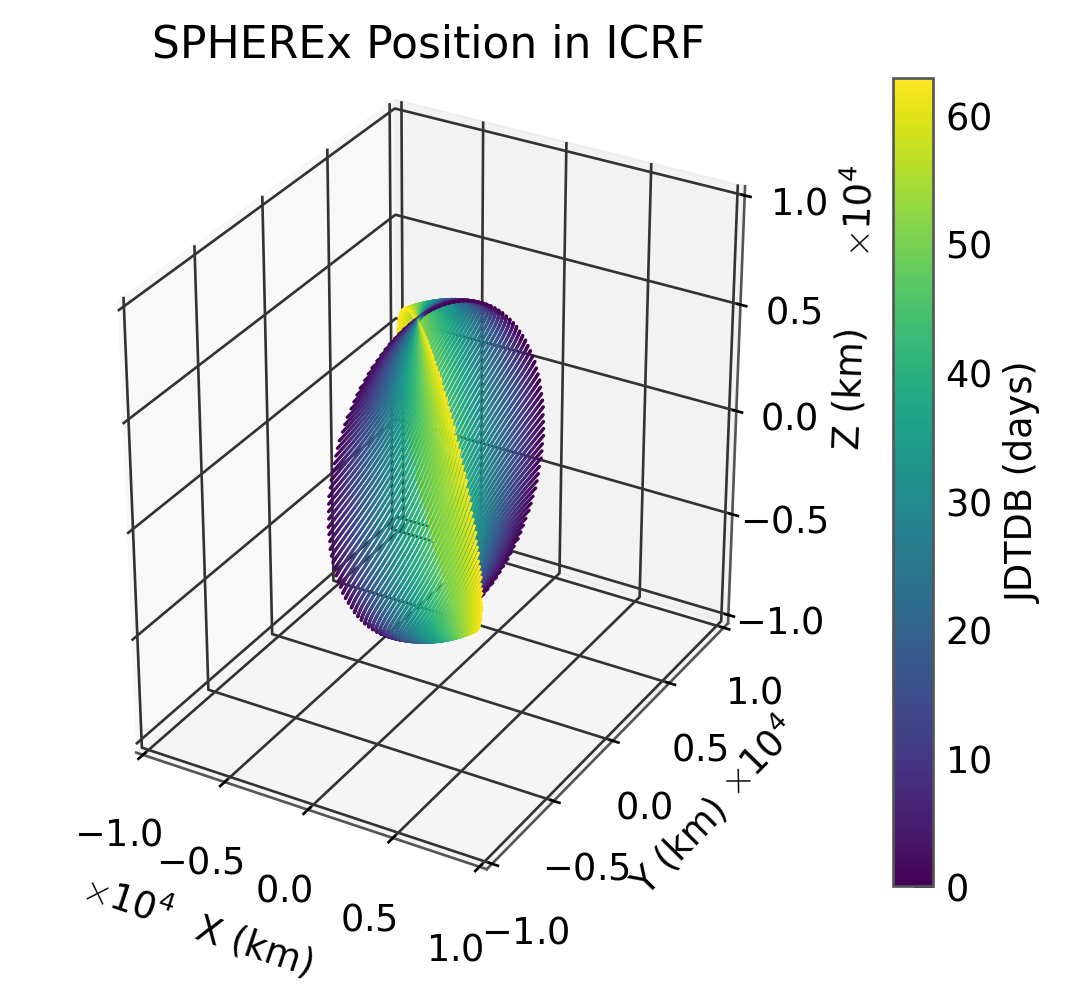

In [ ]:
xyz = []
# mintime = table['JDTDB'][-1]
# geocentric = sat.at(ts.tdb_jd(mintime))
# geocentric.xyz.km
for t in table['JDTDB']:
    t = ts.tdb_jd(t)
    geocentric = sat.at(t)
    xyz.append(geocentric.xyz.km) # convert to km
xyz = np.array(xyz)
x,y,z = xyz[:,0],xyz[:,1],xyz[:,2]

fig = plt.figure()
ax = cast(Axes3D, fig.add_subplot(111, projection='3d'))

ax.set_xlabel('X (km)')
ax.set_ylabel('Y (km)')
ax.set_zlabel('Z (km)')
ax.set_title('SPHEREx Position in ICRF')

ax.scatter(x, y, z, c = table['JDTDB'] - table['JDTDB'].min(), cmap='viridis', marker='.', s=1, alpha=1, linewidth=0.5)
plt.colorbar(ax.collections[0], label='JDTDB (days)')
ax.set_aspect('equal')
ax.set_xlim([-10000, 10000])
ax.set_ylim([-10000, 10000])
ax.set_zlim([-10000, 10000])

# Why can't we just use the same TLE for all time

We could, but it is imprecise. The TLE for an orbit changes constantly for a satellite

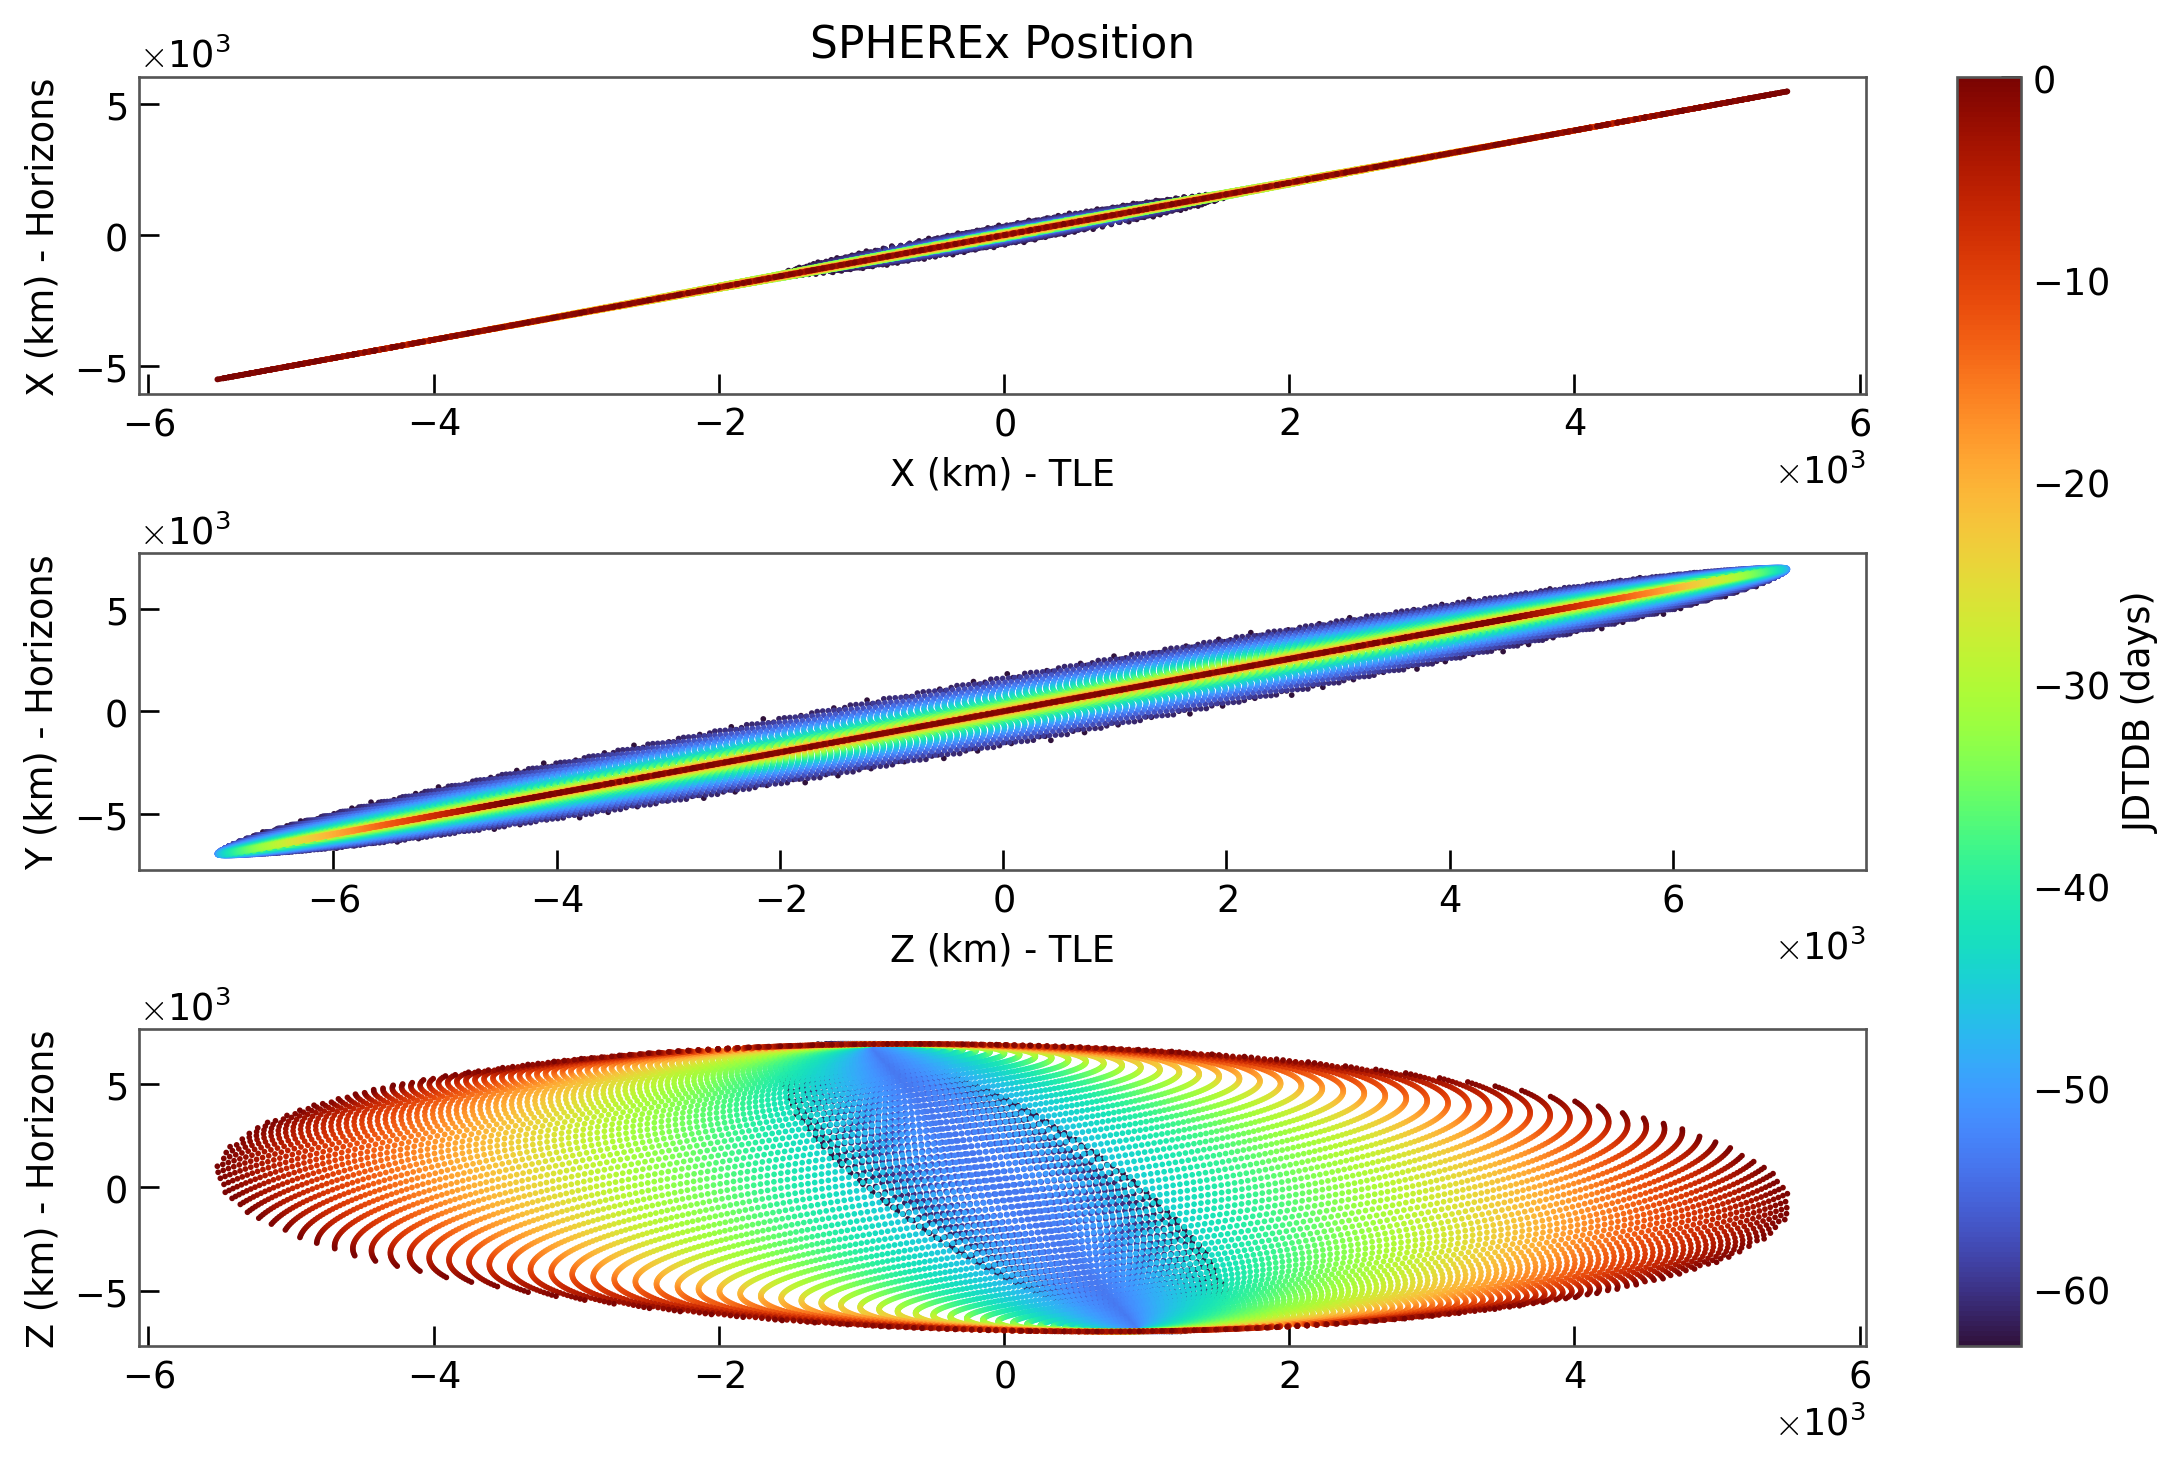

In [ ]:
# compare horizons and TLE

fig = plt.figure(figsize=(9, 6))
  # 3 rows, 1 column
ax_x = fig.add_subplot(311)
ax_y = fig.add_subplot(312)
ax_z = fig.add_subplot(313)

ax_x.set_title('SPHEREx Position')
ax_x.set_ylabel('X (km) - Horizons')
ax_y.set_ylabel('Y (km) - Horizons')
ax_z.set_ylabel('Z (km) - Horizons')
ax_x.set_xlabel('X (km) - TLE')
ax_y.set_xlabel('Y (km) - TLE')
ax_y.set_xlabel('Z (km) - TLE')


jd_max = table['JDTDB'].max()

cmap = 'turbo'

ax_x.scatter(x, table['X'], c = table['JDTDB'] - jd_max,  marker='.', linestyle='', s=2, alpha=1, linewidth=0.5, cmap = cmap)
ax_y.scatter(y, table['Y'], c = table['JDTDB'] - jd_max,  marker='.', linestyle='', s=2, alpha=1, linewidth=0.5, cmap = cmap)
ax_z.scatter(x, table['Z'], c = table['JDTDB'] - jd_max,  marker='.', linestyle='', s=2, alpha=1, linewidth=0.5, cmap = cmap)

# single colorbar for all figues
cbar = fig.colorbar(ax_x.collections[0], ax=[ax_x, ax_y, ax_z], label='JDTDB (days)')

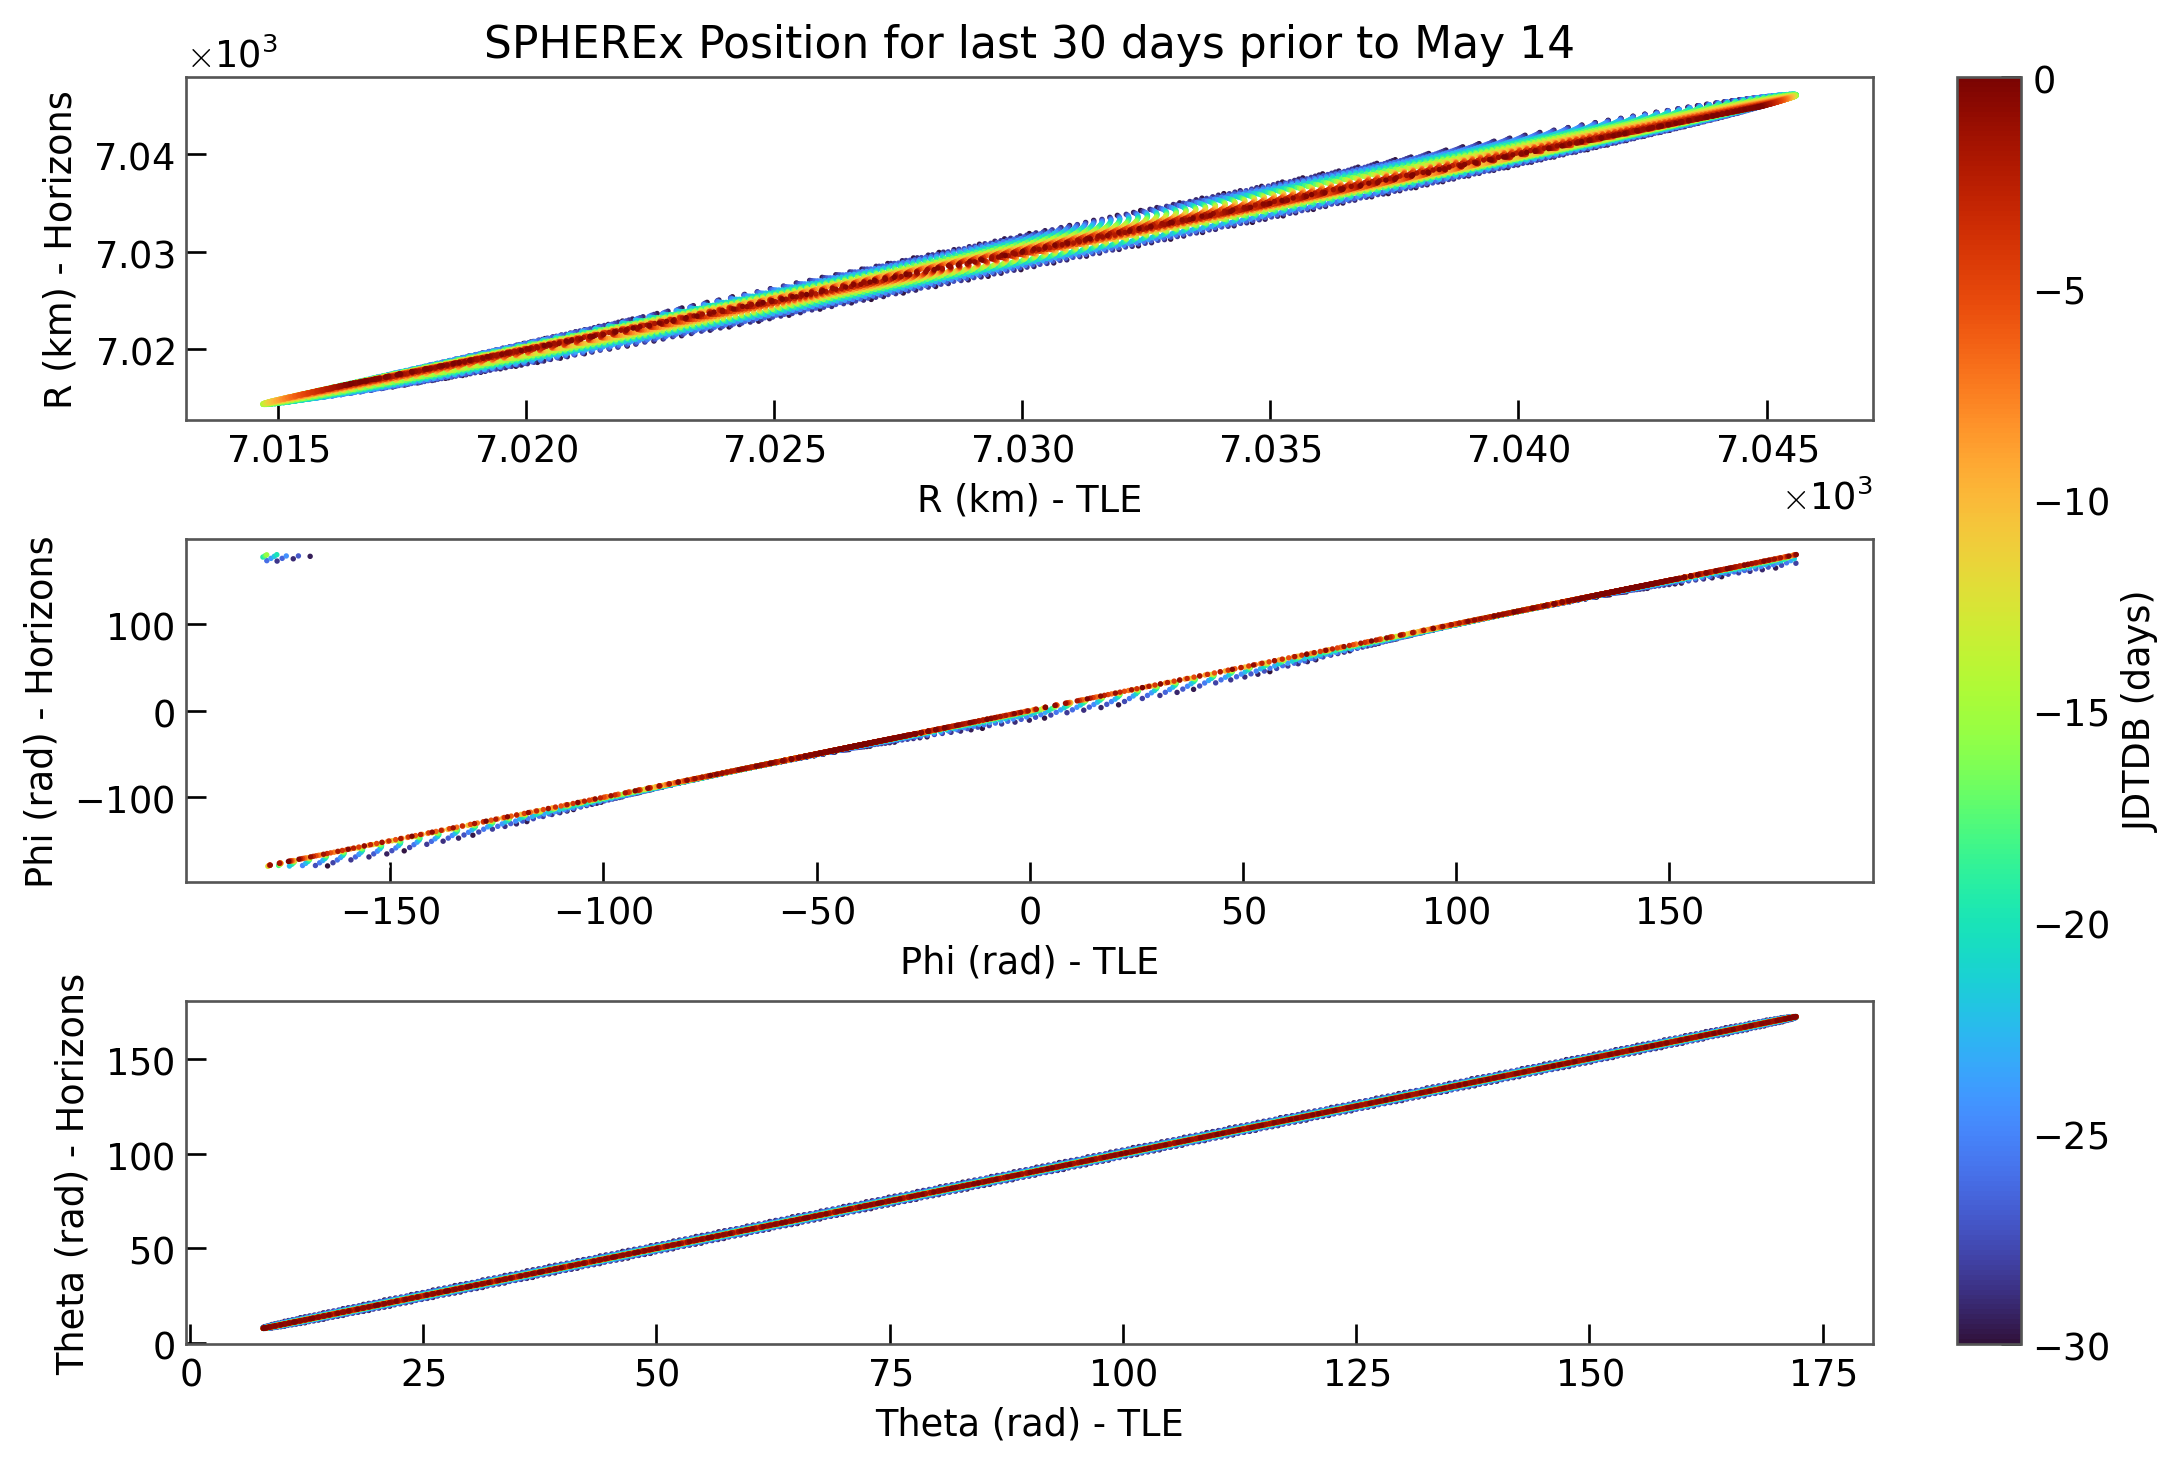

In [21]:
# convert x, y, z, to r, phi, theta for TLE and horizons
horizons_r = np.sqrt(table['X']**2 + table['Y']**2 + table['Z']**2)
horizons_phi = np.arctan2(table['Y'], table['X']) * 180 / np.pi
horizons_theta = np.arctan2(np.sqrt(table['X']**2 + table['Y']**2), table['Z']) * 180 / np.pi
tle_r = np.sqrt(x**2 + y**2 + z**2) 
tle_phi = np.arctan2(y, x) * 180 / np.pi
tle_theta = np.arctan2(np.sqrt(x**2 + y**2), z) * 180 / np.pi


fig = plt.figure(figsize=(9, 6))
  # 3 rows, 1 column
ax_r = fig.add_subplot(311)
ax_phi = fig.add_subplot(312)
ax_theta = fig.add_subplot(313)

ax_r.set_title('SPHEREx Position for last 30 days prior to May 14')
ax_r.set_ylabel('R (km) - Horizons')
ax_phi.set_ylabel('Phi (rad) - Horizons')
ax_theta.set_ylabel('Theta (rad) - Horizons')
ax_r.set_xlabel('R (km) - TLE')
ax_phi.set_xlabel('Phi (rad) - TLE')
ax_theta.set_xlabel('Theta (rad) - TLE')
# Generated by Copilot
jd_max = table['JDTDB'].max()

cmap = plt.get_cmap('turbo')
cmap.set_under('#ffffff00')  # Set color for values below vmin

ax_r.scatter(tle_r, horizons_r, c=table['JDTDB'] - jd_max, cmap=cmap, marker='.', s=5, alpha=1, linewidth=0.5, vmin=-30)
ax_phi.scatter(tle_phi, horizons_phi, c=table['JDTDB'] - jd_max, cmap=cmap, marker='.', s=5, alpha=1, linewidth=0.5, vmin=-30)
ax_theta.scatter(tle_theta, horizons_theta, c=table['JDTDB'] - jd_max, cmap=cmap, marker='.', s=5, alpha=1, linewidth=0.5, vmin=-30)

cbar = fig.colorbar(ax_r.collections[0], ax=[ax_r, ax_phi, ax_theta], label='JDTDB (days)')